In [1]:
suppressPackageStartupMessages(suppressWarnings(library(lintr))) # linting
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridgeline plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # color palettes
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(png))

In [2]:
# helper functions
load_image <- function(path){
    img <- png::readPNG(path)
    # Convert the image to a raster object
    g <- grid::rasterGrob(img, interpolate=TRUE)

    # Create a ggplot
    p <- ggplot() +
    annotation_custom(g, xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf) +
    theme_void()
    return(p)
}

In [3]:
# getting all paths

# confusing matrix paths
confusion_matrix_path <- file.path("../../results/2.modeling/confusion_matrix.csv.gz")
overlapping_confusion_matrix_path <- file.path("../../results/2.modeling/jump_overlap_confusion_matrix.csv.gz")

# f1 score path
f1_score_path <- file.path("../../results/2.modeling/all_f1_scores.csv.gz")

# precision and recall curve path
pr_file_path <- file.path("../../results/2.modeling/precision_recall_scores.csv.gz")

# probability plot
proba_path <- file.path("../../results/3.jump_analysis/JUMP_injury_proba.csv.gz")

# path to workflow image
wf_image <- file.path("./figures/workflow_fig.png")

# create figures and supplemental dir
dir.create("figures/supplemental", recursive = TRUE)

Warning message in dir.create("figures/supplemental", recursive = TRUE):
“'figures/supplemental' already exists”


In [4]:
# loading all data

# loading confusion matrices
cm_df <- read.csv(confusion_matrix_path, sep = ",")
overlapping_cm_df <- read.csv(overlapping_confusion_matrix_path, sep = ",")

# loading f1 score paths
f1_df <- read.csv(f1_score_path, sep = ",")

# loading pr curve data
pr_df <- read.csv(pr_file_path)

# loading probabilities
proba_df <- read.table(proba_path, head = TRUE, sep=",")

# loading workflow image
fig2_A_wf_image <- load_image(wf_image)

In [5]:
# pre-formatting data before plotting

# update one of the shuffled_model columns to Shuffled and Not Shuffled
cm_df$shuffled_model <- ifelse(cm_df$shuffled_model == "False", "Not Shuffled",
                            ifelse(cm_df$shuffled_model == "True", "Shuffled", cm_df$shuffled_model))

# update one of the shuffled_model columns to Shuffled and Not Shuffled
overlapping_cm_df$shuffled_model <- ifelse(overlapping_cm_df$shuffled_model == "False", "Not Shuffled",
                            ifelse(overlapping_cm_df$shuffled_model == "True", "Shuffled", overlapping_cm_df$shuffled_model))

# replacing True and False to shuffled to non shuffled
f1_df$shuffled <- ifelse(f1_df$shuffled == "False", "Not Shuffled",
                                      ifelse(f1_df$shuffled == "True", "Shuffled", f1_df$shuffled))

# update one of the shuffled_model columns to Shuffled and Not Shuffled
pr_df$shuffled <- ifelse(pr_df$shuffled == "False", "Not Shuffled",
                  ifelse(pr_df$shuffled == "True", "Shuffled", pr_df$shuffled))


# replacing True and False to shuffled to non shuffled
# proba_df$shuffled_model <- ifelse(proba_df$shuffled_model == "False", "Not Shuffled",
                                    #   ifelse(proba_df$shuffled_model == "True", "Shuffled", proba_df$shuffled_model))

## Figure 2 Panel A: Workflow Diagram

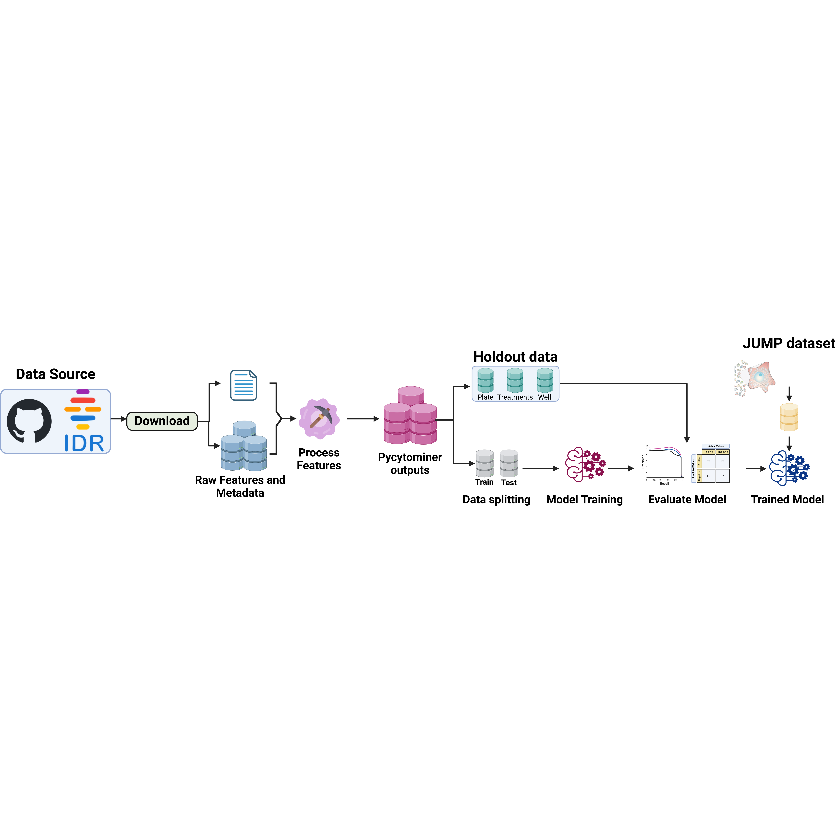

In [6]:
fig2_A_wf_image

## Figure 2 Panel B: PR Cruves for Train and Test split

In [7]:
# Filter the dataframe to select only "test", "train", and "plate_holdout" datasets
filtered_pr_df <- pr_df %>%
  filter(dataset_type %in% c("Test", "Train"))

# Create line_id column
filtered_pr_df <- filtered_pr_df %>%
  mutate(line_id = case_when(
    dataset_type == "Test" & shuffled == "Not Shuffled" ~ "Test + Not Shuffled",
    dataset_type == "Test" & shuffled == "Shuffled" ~ "Test + Shuffled",
    dataset_type == "Train" & shuffled == "Not Shuffled" ~ "Train + Not Shuffled",
    dataset_type == "Train" & shuffled == "Shuffled" ~ "Train + Shuffled",
  )) %>%
  mutate(is_train_test = if_else(dataset_type %in% c("test", "train"), "test_train", "plate_holdout"))

# plot data
width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)

fig2_D_pr_curve_plot_train_test <- ggplot(filtered_pr_df, aes(x = recall, y = precision)) +
    geom_line(aes(color = dataset_type, linetype = shuffled)) +
    facet_wrap(~injury_type) +
    xlab("Recall") +
    ylab("Precision") +
    theme_bw() +
    theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.1, "cm"),
        legend.key.size = unit(0.7, "lines"),
        legend.key.width = unit(1, "lines"),
        axis.text.x = element_text(angle = 90, size = 16),
        axis.text.y = element_text(size = 16),
        strip.text = element_text(size = 17),
        strip.text.x = element_text(margin = margin(t=0.2, b=0.2, r=0, l=0, "cm")),
        axis.title = element_text(size = 17),
        legend.title = element_text(size = 17),
        legend.text = element_text(size = 17)) +
    labs(color = "Data Split", linetype = "Shuffled")

ggsave("figures/fig2_B_only_test_train_pr_curve.png", width = width, height = height, dpi=600)

fig2_B_pr_curve_plot_train_test

ERROR: Error in eval(expr, envir, enclos): object 'fig2_B_pr_curve_plot_train_test' not found


## Figure 2 Panel C: Creating F1 score plots 

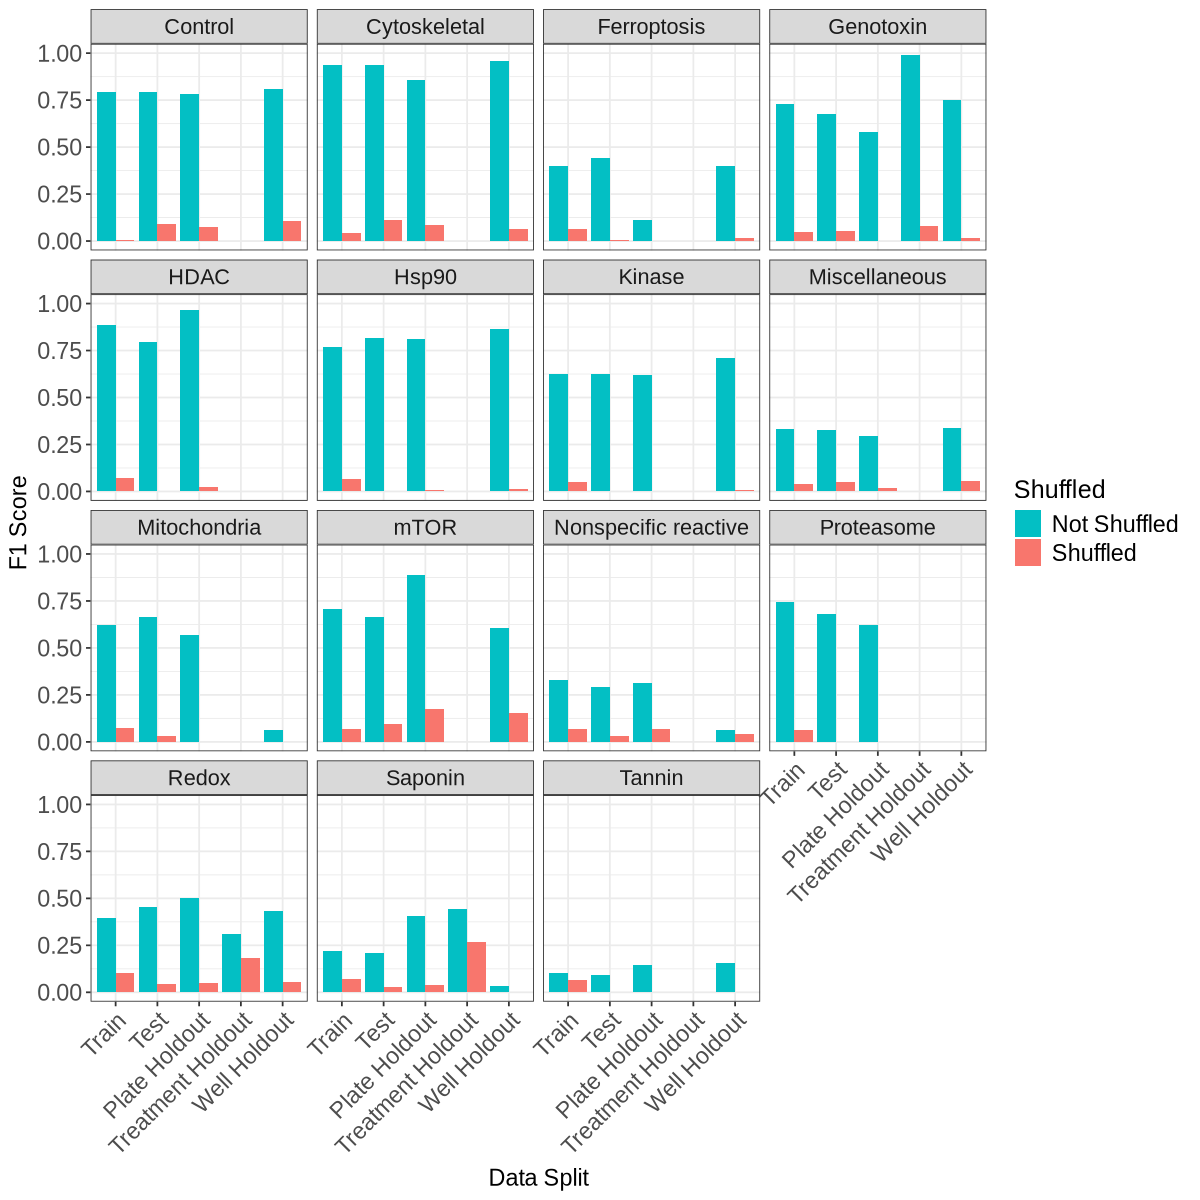

In [ ]:
# image size
img_height <- 10
img_width <- 10

options(repr.plot.width = img_width, repr.plot.height = img_height)

# creating a bar plot with a facet grid dictated by whether the model has been shuffled or not
# along the y, facet grid was generated based on the dataset type
legend_order <- c("Train", "Test", "Plate Holdout", "Treatment Holdout", "Well Holdout")

fig2_C_f1_bar_plot <- ggplot(f1_df, aes(x = factor(dataset_type, levels = legend_order), y = f1_score, fill = shuffled)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_bw() +
  ylim(0, 1) +
  facet_wrap(~injury_type) +
  labs(y = "F1 Score", x = "Data Split", fill = "Shuffled") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        axis.text.y = element_text(hjust = 1, size = 14),
        legend.title = element_text(size = 15),
        legend.text = element_text(size = 14),
        strip.text = element_text(size = 13),
        axis.title.y = element_text(size = 14),
        axis.title.x = element_text(size = 14)
        ) +
  scale_fill_manual(values = c(
      "Shuffled" = "#f8766d",
      "Not Shuffled" = "#03bfc4"
    ))

ggsave(filename = "figures/fig2_C_f1_score_barplots.png", height = img_height, width = img_width, dpi = 600)
fig2_C_f1_bar_plot

## Figure 2 Panel D: Confusion Matrix with Train and Test split

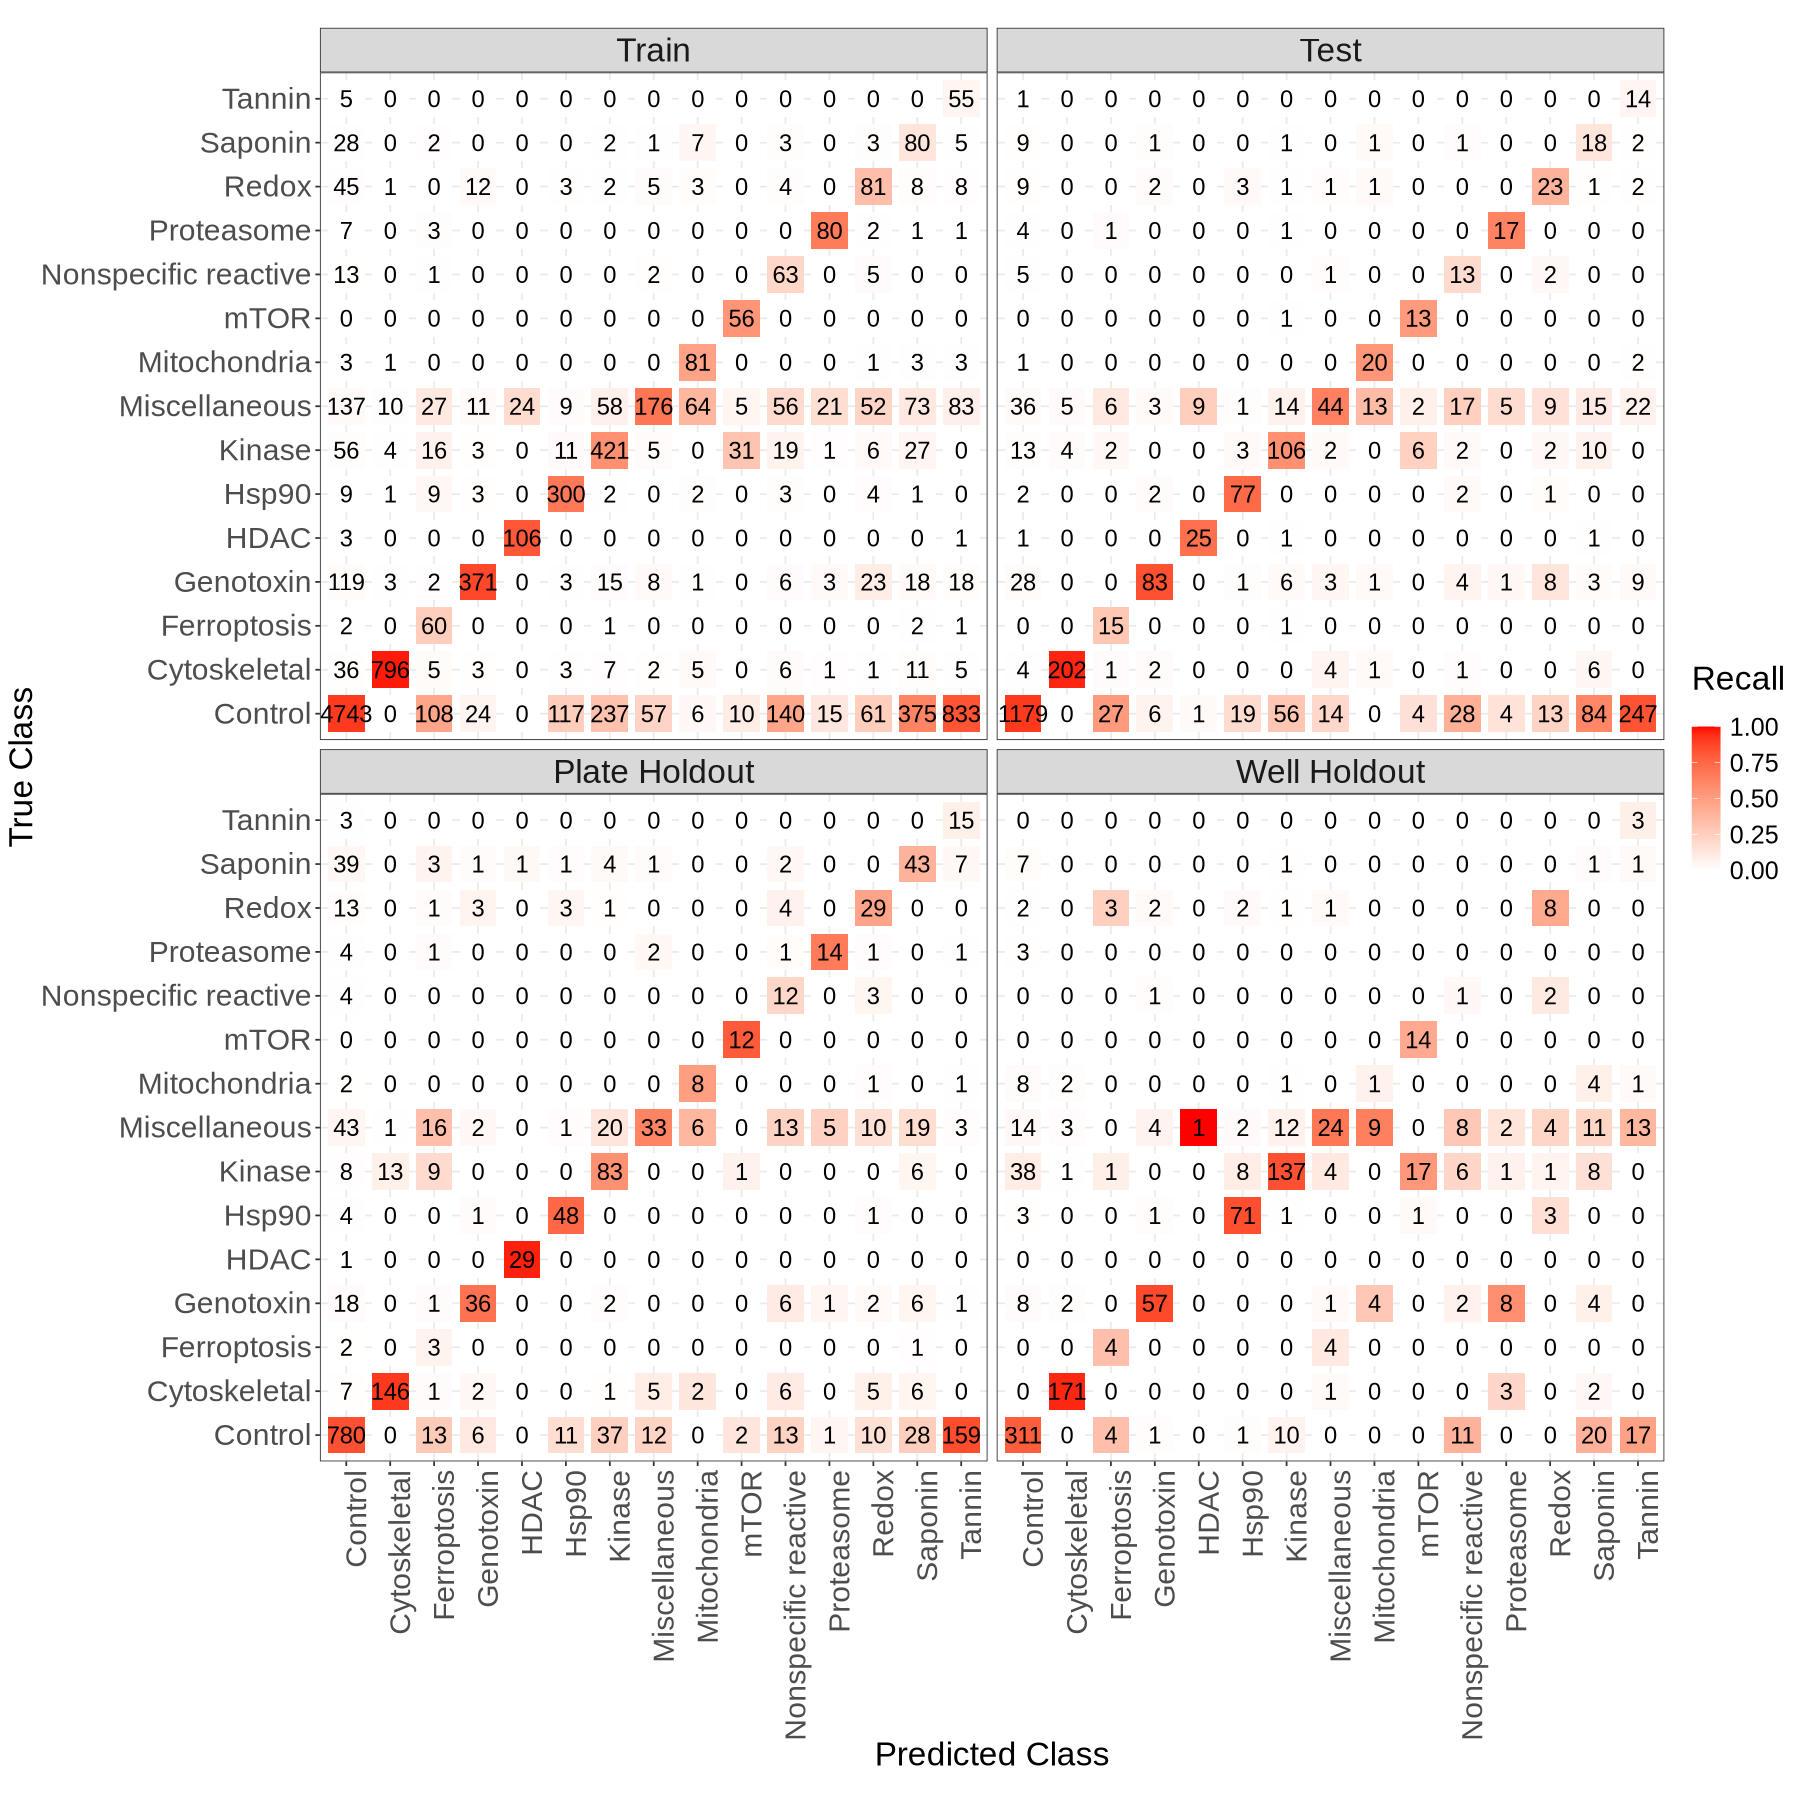

In [ ]:

# creating final model confusion matrix with Non-shuffled data
final_model_cm <- cm_df %>%
  filter(shuffled_model == "Not Shuffled" & dataset_type %in% c("Train", "Test", "Plate Holdout", "Well Holdout"))

# Define the desired order of facet levels
# facet_order <- c("Train", "Test", "Plate Holdout", "Treatment Holdout", "Well Holdout")
facet_order <- c("Train", "Test", "Plate Holdout", "Well Holdout")
final_model_cm$dataset_type <- factor(final_model_cm$dataset_type, levels = facet_order)

width <- 15
height <- 15
options(repr.plot.width = width, repr.plot.height = height)

fig2_D_final_model_cm <- (
    ggplot(final_model_cm, aes(x = predicted_labels, y = true_labels))
    + facet_wrap(~dataset_type)
    + geom_point(aes(color = recall), size = 10, shape = 15)
    + geom_text(aes(label = count), size = 5)
    + scale_color_gradient("Recall", low = "white", high = "red", limits = c(0, 1))
    + theme_bw()
    + xlab("Predicted Class")
    + ylab("True Class")
    + theme(
        # legend settings
        legend.title =  element_text(size = 20, margin = margin(b = 20)),
        legend.text = element_text(size = 15),

        strip.text = element_text(size = 20),
        axis.text.x = element_text(angle = 90, hjust = 1, size = 18),
        axis.text.y = element_text(hjust = 1, size = 18),
        axis.title.x.bottom = element_text(size = 20),
        axis.title.y.left = element_text(size = 20)
        )
    + ggplot2::coord_fixed()
)

# saving file
ggsave(filename = "figures/fig2_D_training_confusion_matrix.png", height = height, width = width, dpi = 600)

fig2_D_final_model_cm

## Supplemental Figure 2: Confusion matrix with Shuffled model 

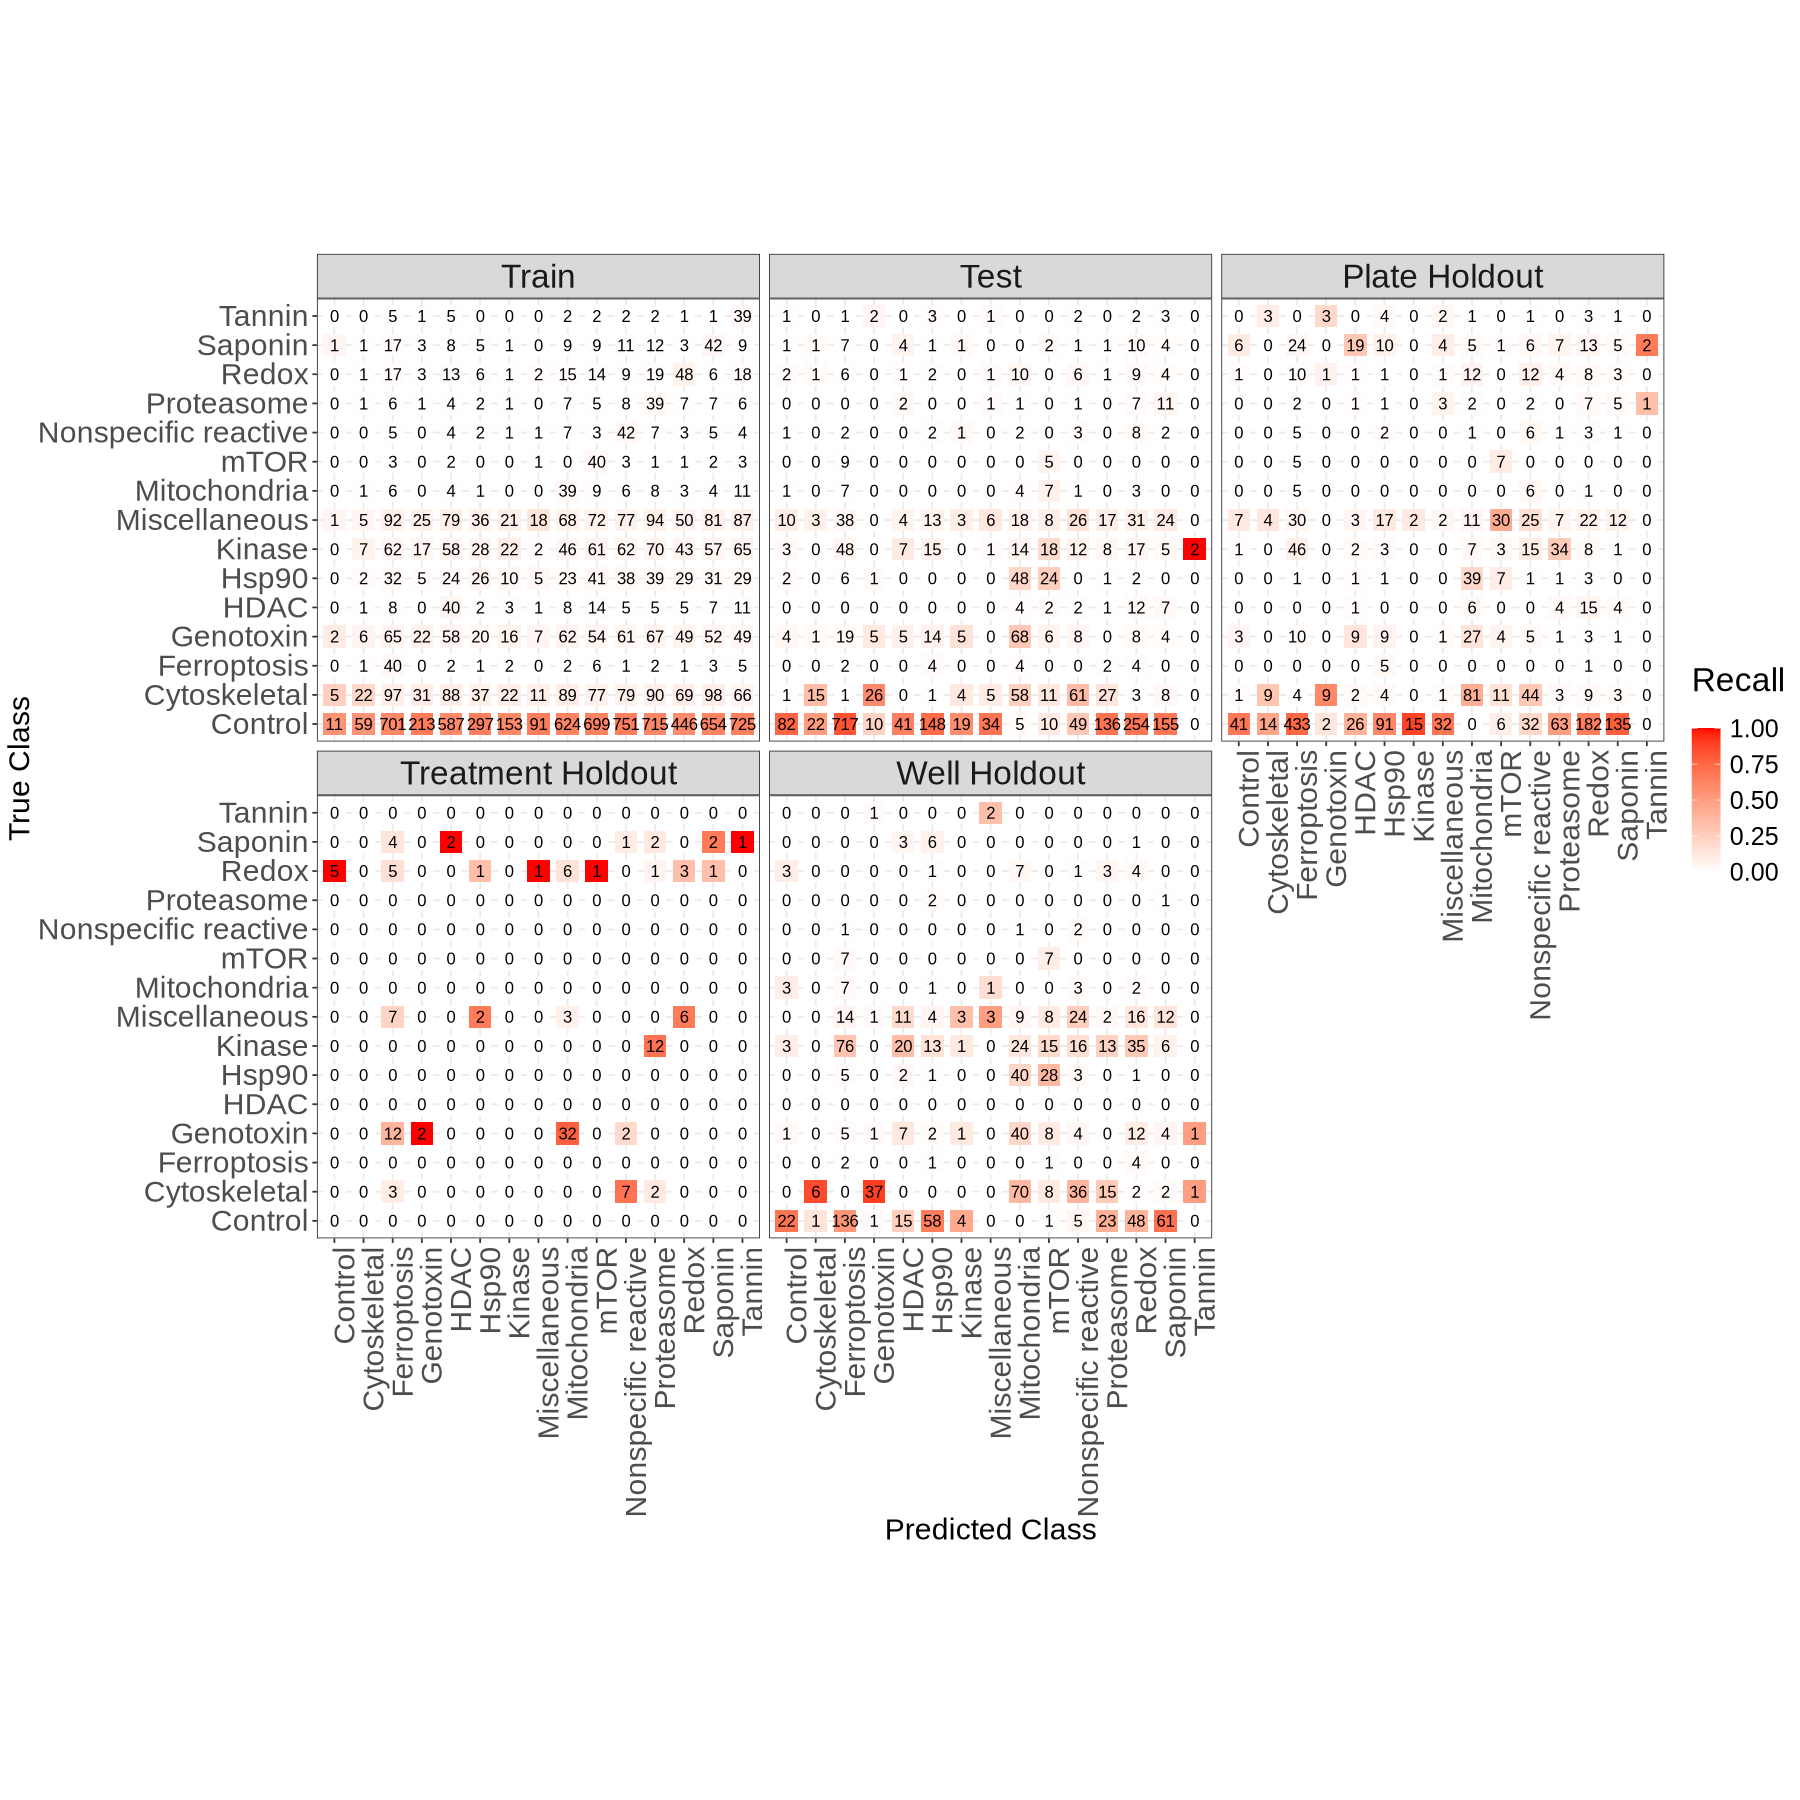

In [ ]:

# creating final model confusion matrix with Non-shuffled data
final_model_cm <- cm_df %>%
  filter(shuffled_model == "Shuffled" & dataset_type %in% c("Train", "Test", "Plate Holdout", "Treatment Holdout", "Well Holdout"))


# Define the desired order of facet levels
facet_order <- c("Train", "Test", "Plate Holdout", "Treatment Holdout", "Well Holdout")
final_model_cm$dataset_type <- factor(final_model_cm$dataset_type, levels = facet_order)

width <- 15
height <- 15
options(repr.plot.width = width, repr.plot.height = height)

sfig2_model_cm <- (
    ggplot(final_model_cm, aes(y = true_labels, x = predicted_labels))
    + facet_wrap(~dataset_type)
    + geom_point(aes(color = recall), size = 6, shape = 15)
    + geom_text(aes(label = count), size = 3.5)
    + scale_color_gradient("Recall", low = "white", high = "red", limits = c(0, 1))
    + theme_bw()
    + xlab("Predicted Class")
    + ylab("True Class")
      + theme(
        # legend settings
        legend.title =  element_text(size = 20, margin = margin(b = 20)),
        legend.text = element_text(size = 15),
        strip.text = element_text(size = 20),
        axis.text.x = element_text(angle = 90, hjust = 1, size = 18),
        axis.text.y = element_text(hjust = 1, size = 18),
        axis.title.x.bottom = element_text(size = 18),
        axis.title.y.left = element_text(size = 18)
        )
    + ggplot2::coord_fixed()
)

# saving file
ggsave(filename = "figures/supplemental/sfig2_shuffled_confusion_matrix.png", height = height, width = width, dpi = 600)

sfig2_model_cm

## Supplmental Figure Y: PR Curve of the plate holdouts

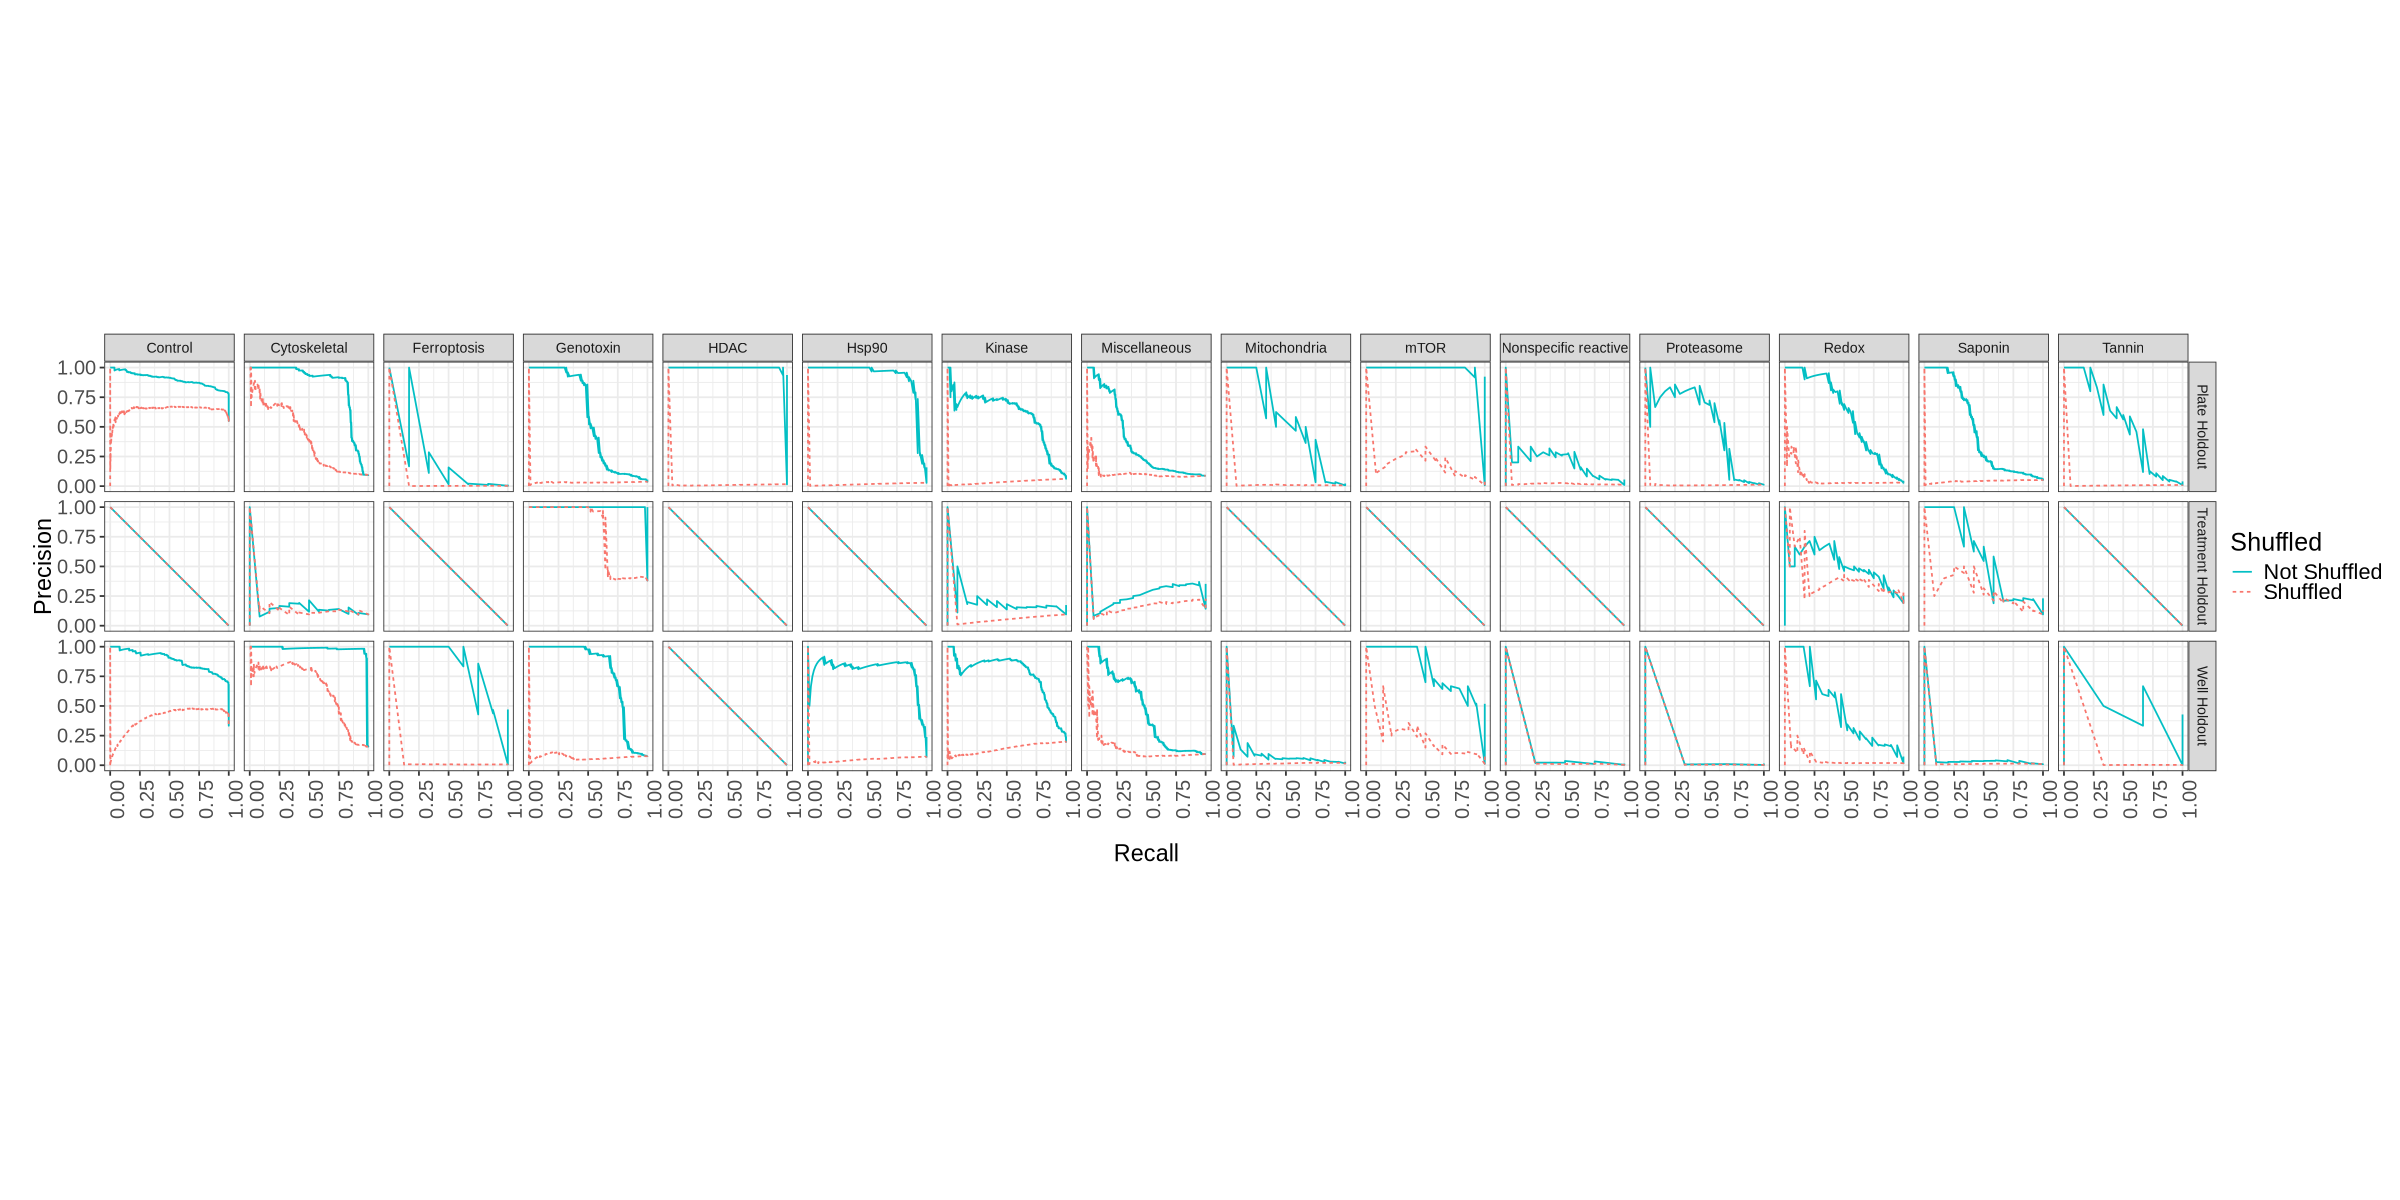

In [ ]:
# creating data frame with only the holdout scores
dataset_order <- c("Plate Holdout", "Treatment Holdout", "Well Holdout")
holdout_pr_df <- pr_df %>%
  filter(dataset_type %in% dataset_order)
holdout_pr_df$dataset_type <- factor(holdout_pr_df$dataset_type, levels = dataset_order)


# Set plot dimensions
width <- 20
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

# Create the plot
holdout_pr_curve_plot <- ggplot(holdout_pr_df, aes(x = recall, y = precision, color = shuffled)) +
  geom_line(aes(linetype = shuffled)) +
  facet_grid(dataset_type ~ injury_type) +
  theme_bw() +

  theme(
    legend.spacing.y = unit(0.1, "cm"),
    legend.box.spacing = unit(0.1, "cm"),
    legend.key.size = unit(0.7, "lines"),
    legend.key.width = unit(1, "lines"),
    legend.title = element_text(size = 15),
    legend.text = element_text(size = 13),

    # facet params
    strip.text = element_text(size = 8.5),
    # strip.text.x = element_text(margin = margin(2,2,2,2, "cm")),

    # axis params
    axis.text.x = element_text(angle = 90, size = 12),
    axis.text.y = element_text(size = 12),
    axis.title = element_text(size = 14),
    axis.title.x.bottom = element_text(margin = margin(t = 15)),
    axis.title.y.left = element_text(margin = margin(l = 15))
    ) +

 scale_color_manual(values = c(
      "Shuffled" = "#f8766d",
      "Not Shuffled" = "#03bfc4"
    )) +

labs(x = "Recall", y = "Precision", linetype = "Shuffled", color = "Shuffled") +
coord_fixed()

# Save the plot
ggsave("figures/supplemental/sfig_holdout_pr_curves.png", width = width, height = height, dpi = 600)
holdout_pr_curve_plot


## Figure 1 Panel E: Probabilities

In [ ]:
# image size
img_height <- 15
img_width <- 15

options(repr.plot.width = img_width, repr.plot.height = img_height)
fig2_E_probabilities_ridge_plot <- (
    ggplot(proba_df, aes(x = proba, y = pred_injury, fill = shuffled_model)) +
    geom_density_ridges() +
    facet_wrap(~injury_type) +
    scale_x_continuous(breaks = seq(0, 1, 0.5)) +
    theme_bw() +

    # no legend
    theme(plot.title = element_text(size = 20, hjust = 0.5)) +

    # scale_fill_manual(values = c(
    # "True" = brewer.pal(2, "Dark2")[2],
    # "False" = "#1E93FC"
    # )) +

    theme(
        axis.title.x = element_blank(),
        strip.text = element_text(size = 16),
        axis.text.x = element_text(size = 14),
        axis.text.y = element_text(size = 14),
        axis.title = element_text(size = 15),
        axis.title.y.left = element_text(margin = margin(t = 15)),
        axis.title.x.bottom = element_text(margin = margin(t = 15)),

        # legend
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 15),
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.2, "cm"),
        legend.key.size = unit(0.7, "lines"),
        legend.key.width = unit(1, "lines"),
        )) +

    labs(y = "Injury Types", x = "Probability", fill = "Model Type")


ggsave(filename = "figures/fig2_E_JUMP_cell_injury_facet_proba.png", height = img_height, width = img_width, dpi=600)
fig2_E_probabilities_ridge_plot

ERROR: Error in ggplot(proba_df, aes(x = proba, y = pred_injury, fill = shuffled_model)): could not find function "ggplot"


In [ ]:
proba_df

Metadata_InChIKey           shuffled_model pred_injury         
1                                  False          Ferroptosis         
2                                  False          Mitochondria        
3                                  False          Mitochondria        
4                                  False          Mitochondria        
5                                  False          Mitochondria        
6                                  False          Mitochondria        
7                                  False          Mitochondria        
8                                  False          Mitochondria        
9                                  False          Mitochondria        
10                                 False          Mitochondria        
11                                 False          Mitochondria        
12                                 False          Mitochondria        
13                                 False          Mitochondria        
14                                 False          Kinase              
15                                 False          Mitochondria        
16                                 False          Kinase              
17                                 False          Mitochondria        
18                                 False          Mitochondria        
19                                 False          Mitochondria        
20                                 False          Ferroptosis         
21                                 False          Nonspecific reactive
22                                 False          Kinase              
23                                 False          Mitochondria        
24                                 False          mTOR                
25                                 False          HDAC                
26                                 False          Mitochondria        
27                                 False          Kinase              
28                                 False          HDAC                
29                                 False          Hsp90               
30                                 False          Hsp90               
⋮      ⋮                           ⋮              ⋮                   
584911 IAZDPXIOMUYVGZ-UHFFFAOYSA-N True           Ferroptosis         
584912 VDQLKIBLTMPAHI-UHFFFAOYSA-N True           Saponin             
584913 NXNKJLOEGWSJGI-BKMJKUGQSA-N True           Nonspecific reactive
584914 UIAGMCDKSXEBJQ-UHFFFAOYSA-N True           mTOR                
584915 VSWDORGPIHIGNW-UHFFFAOYSA-N True           mTOR                
584916 ZESFDAKNYJQYKO-UHFFFAOYSA-N True           Tannin              
584917 RNSLRQNDXRSASX-UHFFFAOYSA-N True           Nonspecific reactive
584918 FPVKHBSQESCIEP-JQCXWYLXSA-N True           Redox               
584919 ICDMLAQPOAVWNH-HAAQQRBASA-N True           Redox               
584920 WJBLNOPPDWQMCH-UHFFFAOYSA-N True           mTOR                
584921 IAZDPXIOMUYVGZ-UHFFFAOYSA-N True           mTOR                
584922 CXUCKELNYMZTRT-UHFFFAOYSA-N True           mTOR                
584923 WGZOTBUYUFBEPZ-UHFFFAOYSA-N True           Genotoxin           
584924 DTGLZDAWLRGWQN-UHFFFAOYSA-N True           mTOR                
584925 ODHCTXKNWHHXJC-VKHMYHEASA-N True           mTOR                
584926 IAZDPXIOMUYVGZ-UHFFFAOYSA-N True           Tannin              
584927 NQDJXKOVJZTUJA-UHFFFAOYSA-N True           Mitochondria        
584928 FNYLWPVRPXGIIP-UHFFFAOYSA-N True           Ferroptosis         
584929 FNHKPVJBJVTLMP-UHFFFAOYSA-N True           Tannin              
584930 CMSMOCZEIVJLDB-UHFFFAOYSA-N True           mTOR                
584931 KVWDHTXUZHCGIO-UHFFFAOYSA-N True           Nonspecific reactive
584932 LLIFMNUXGDHTRO-UHFFFAOYSA-N True           Tannin              
584933 RQVGFDBMONQTBC-UHFFFAOYSA-N True           Redox               
584934 RRGUKTPIGVIEKM-UHFFFAOYSA-N True           HDAC                
584935 NEMHKCNXXRQYRF-UHFFFAOYS

## Supplmental Figure Z: Confusion Matrix Applying JUMP data to Multi-Class Logistic Regression Model

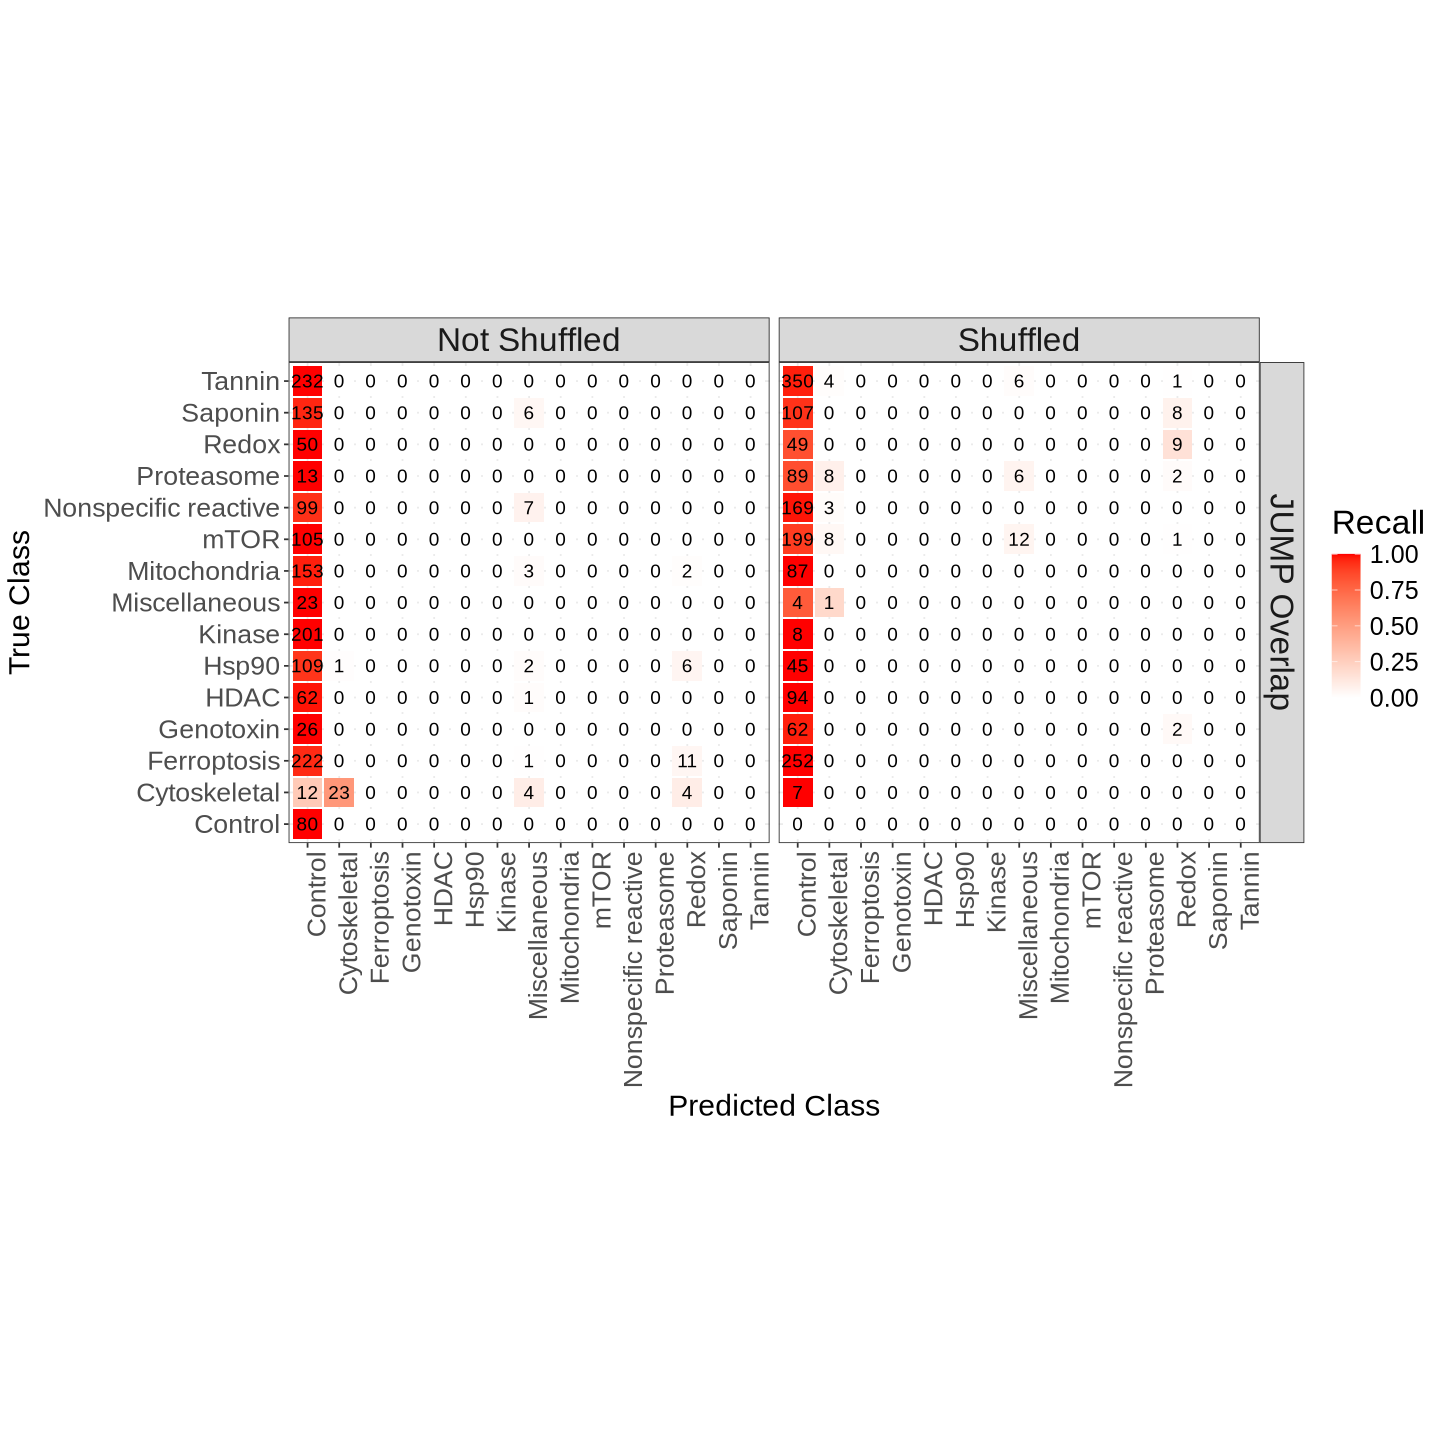

In [ ]:

# set image dim
width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)

# create a confusion matrix plot
overlapping_confusion_matrix_plot <- (
    ggplot(overlapping_cm_df, aes(x = true_labels, y = predicted_labels))
    + facet_grid(dataset_type~shuffled_model)
    + geom_point(aes(color = recall), size = 8, shape = 15)
    + geom_text(aes(label = count), size = 4)
    + scale_color_gradient("Recall", low = "white", high = "red",limits = c(0, 1))
    + theme_bw()
    + ylab("True Class")
    + xlab("Predicted Class")
    + theme(
        legend.title =  element_text(size = 20, margin = margin(b = 10)),
        legend.text = element_text(size = 15),
        strip.text = element_text(size = 20),
        axis.text.x = element_text(angle = 90, hjust = 1, size = 16),
        axis.text.y = element_text(hjust = 1, size = 16),
        axis.title.x.bottom = element_text(size = 18),
        axis.title.y.left = element_text(size = 18),
        )
    + ggplot2::coord_fixed()
)

# saving file
ggsave(filename = "figures/supplemental/overlapping_confusion_matrix.png", height = height, width = width, dpi=600)

overlapping_confusion_matrix_plot

## Finalizing figure2 with patchwork

Picking joint bandwidth of 0.00449

Picking joint bandwidth of 0.00469

Picking joint bandwidth of 0.00318

Picking joint bandwidth of 0.00905

Picking joint bandwidth of 0.00502

Picking joint bandwidth of 0.00628

Picking joint bandwidth of 0.00578

Picking joint bandwidth of 0.00872

Picking joint bandwidth of 0.00506

Picking joint bandwidth of 0.00402

Picking joint bandwidth of 0.00547

Picking joint bandwidth of 0.00578

Picking joint bandwidth of 0.00804

Picking joint bandwidth of 0.00634

Picking joint bandwidth of 0.0034

Picking joint bandwidth of 0.00449

Picking joint bandwidth of 0.00469

Picking joint bandwidth of 0.00318

Picking joint bandwidth of 0.00905

Picking joint bandwidth of 0.00502

Picking joint bandwidth of 0.00628

Picking joint bandwidth of 0.00578

Picking joint bandwidth of 0.00872

Picking joint bandwidth of 0.00506

Picking joint bandwidth of 0.00402

Picking joint bandwidth of 0.00547

Picking joint bandwidth of 0.00578

Picking joint bandwidth of 0.

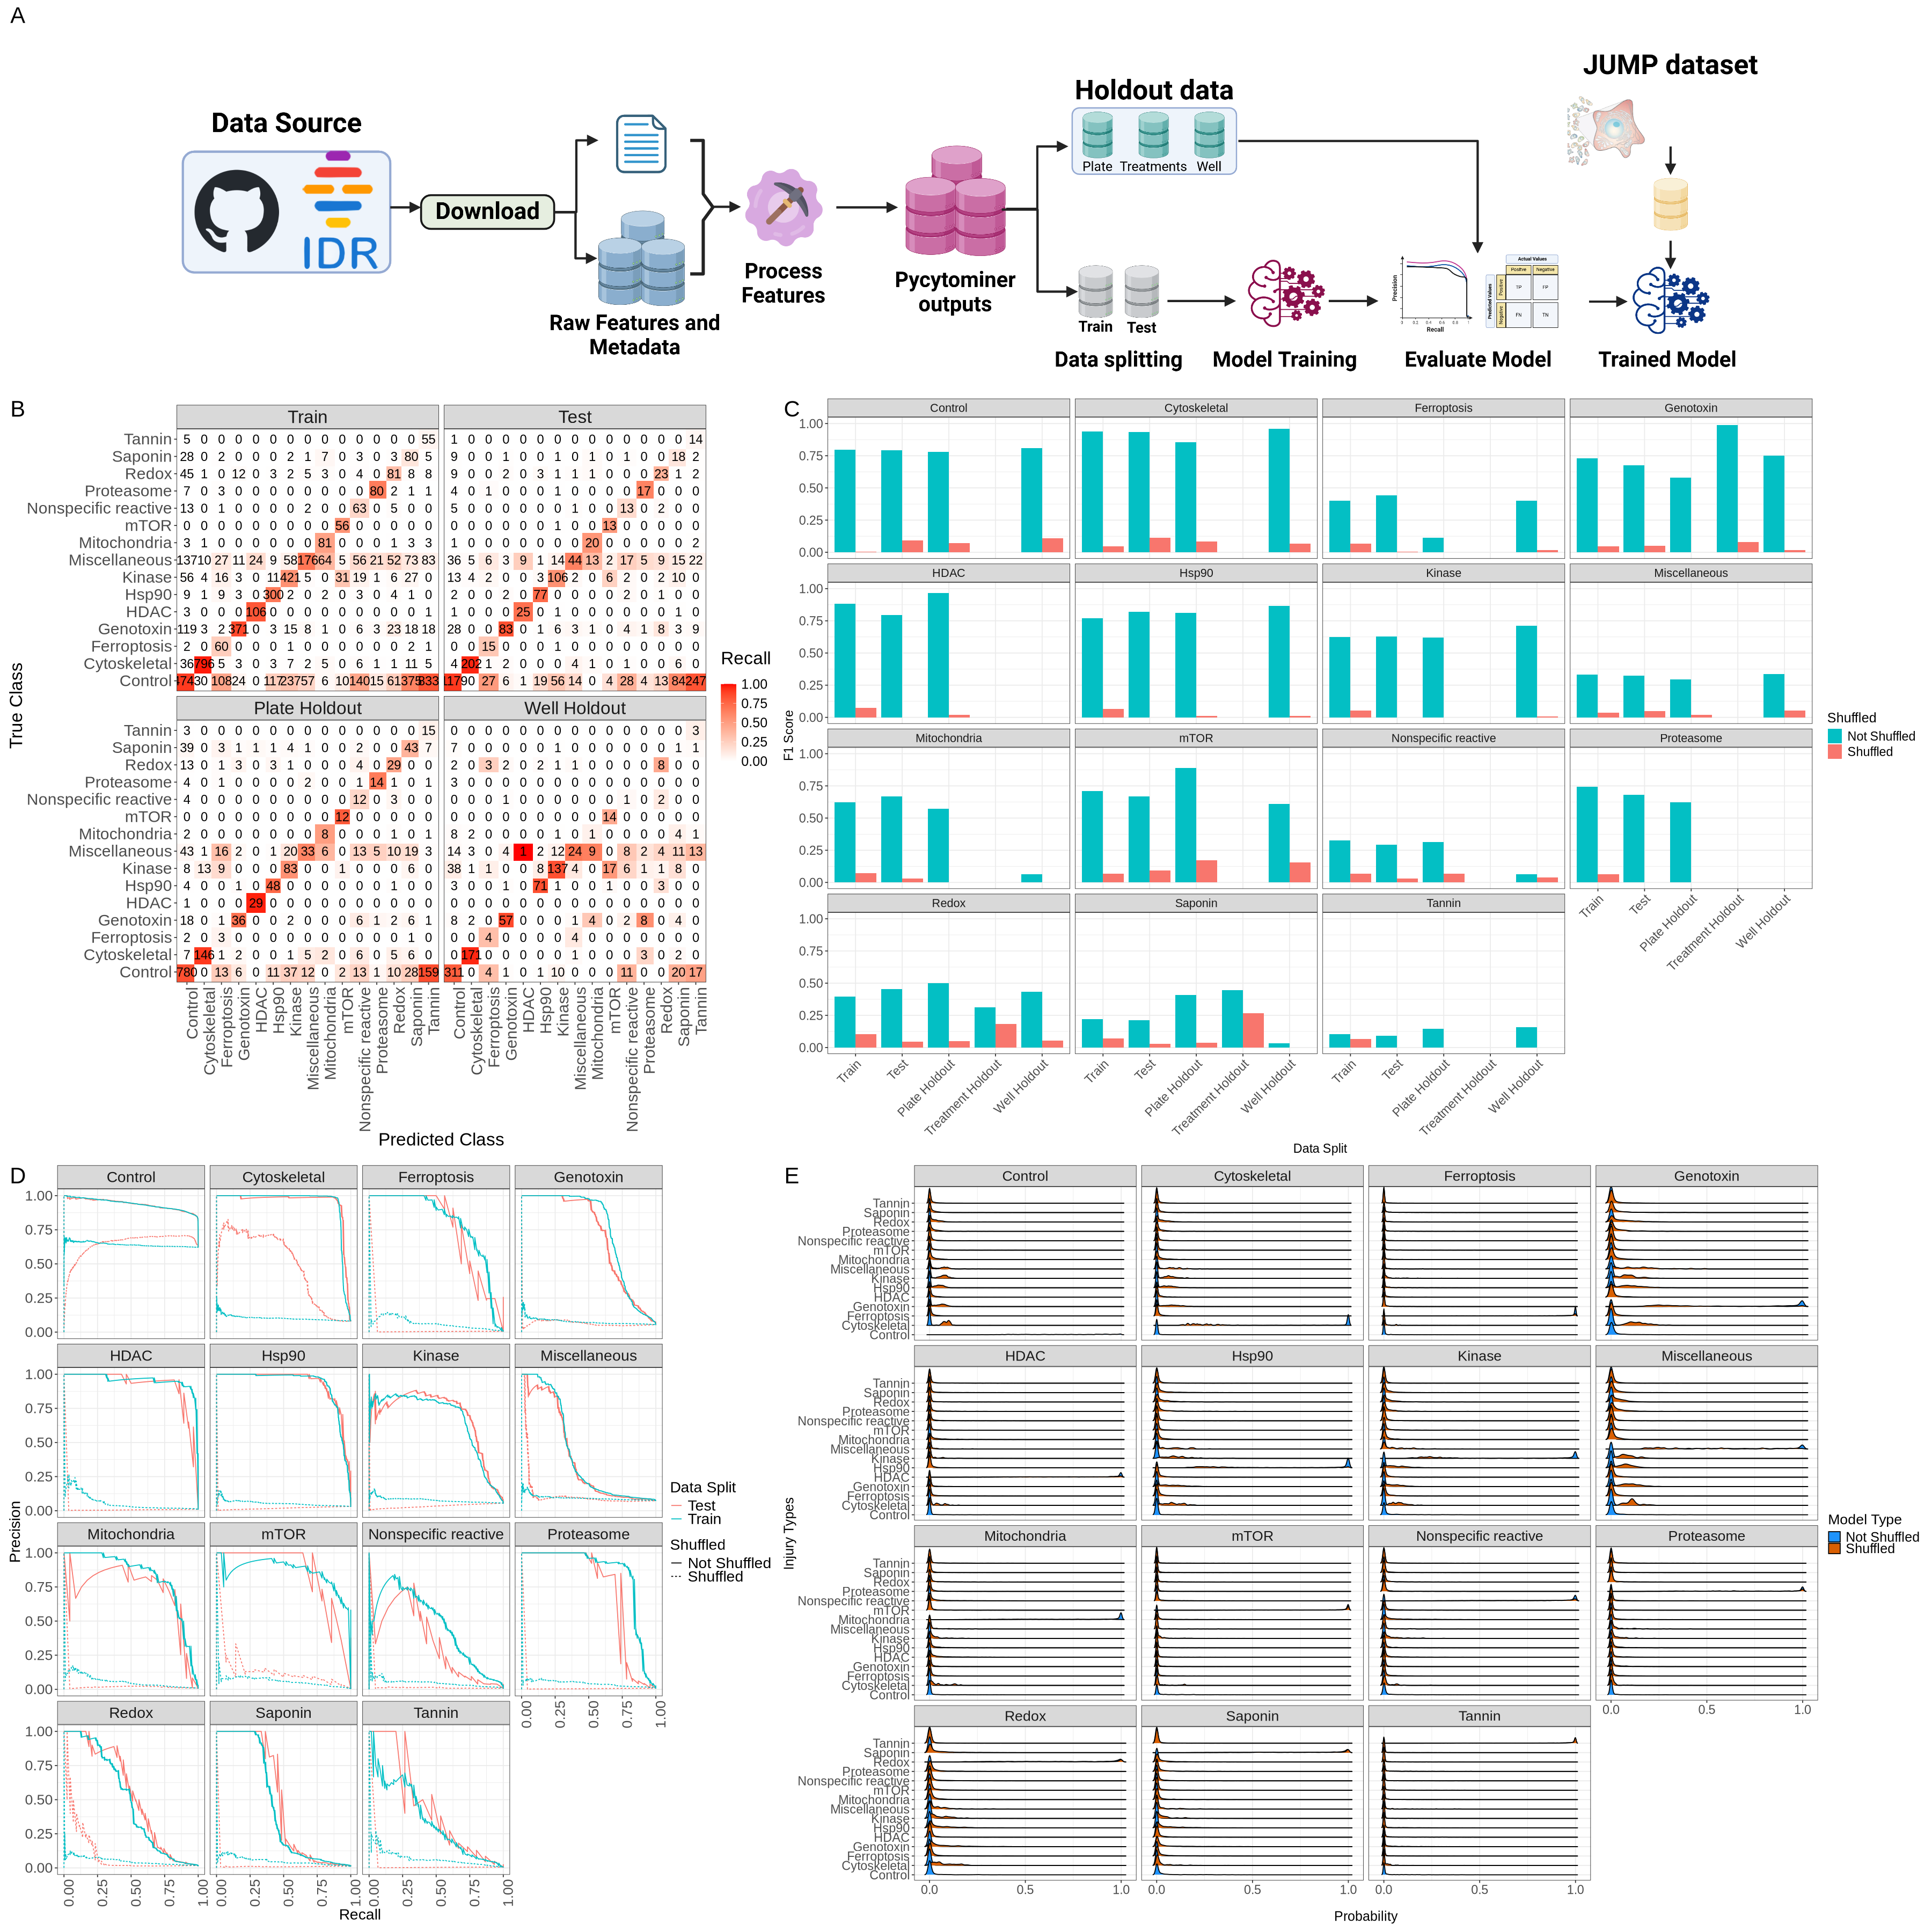

In [ ]:
# Define plot dimensions
height = 30
width = 30


layout <- c(
    area(t=0, b=1, l=0, r=5), # A
    area(t=2, b=3, l=0, r=2), # B
    area(t=2, b=3, l=3, r=5), # C
    area(t=4, b=5, l=0, r=2), # D
    area(t=4, b=5, l=3, r=5) # E
)

options(repr.plot.width=width, repr.plot.height=height, units = "in", dpi = 600)



fig2 <- (
    fig2_A_wf_image
    + wrap_elements(full = fig2_B_final_model_cm)
    + wrap_elements(full = fig2_C_f1_bar_plot)
    + wrap_elements(full = fig2_D_pr_curve_plot_train_test)
    + wrap_elements(full = fig2_E_probabilities_ridge_plot)

    # plot layouts
    + plot_layout(design = layout)#, widths = c(10, 10))
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 25))


)

# Display the combined plot
fig2

# Save the plot
ggsave(
  plot = fig2,
  filename = "Final_Figure2.png",
  height = height,
  width = width,
  dpi = 600
)
